# Data 200: Database Systems and Data Management for Data Analytics


# Project 2: Relational Model

**Dickinson College**<br/>
**Spring 2022**<br/>
**Instructor:** Dick Forrester<br/>
<font color='red'>**Due Date and Time:** 11:59pm on Thursday, 4/28/2022 </font>
---
Enter your name in the markdown cell below.

# Name: Zimeng Liu

**Import `pandas`, `numpy`, `sqlalchemy`, `os.path`, and `matplotlib.pyplot`**

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sa
import os.path
import matplotlib.pyplot as plt

**Create a connection string that that can be used to connect to the `imdb` database using sqlite.**

In [2]:
protocol = "sqlite"
driver = "pysqlite"
database = "imdb"

cstring = f"{protocol}+{driver}:///{os.path.join(database + '.db')}"
print(cstring)

sqlite+pysqlite:///imdb.db


**Establish the connection to the `imdb` database using the connection string `cstring`.**

In [3]:
engine = sa.create_engine(cstring)
connection = engine.connect()

## **_Task 1_**

**A Python function called `analyzeActor(dbcon, actor_name)` that performs SQL queries (to the database with the connection `dbcon`) to determine some interesting facts about the provided actor/actress. Specifically, the function should only examine movies and display the following information:**
1. The first appearance of the actor (title of movie, year the movie premiered, the character the actor played, and the age of the actor at that time).
2. The last appearance of the actor (title of movie, year the movie premiered, the character the actor played, and the age of the actor at that time).
3. The actor’s lowest rated movie.
4. The actor’s highest rated movie.
5. A line graph of the number of movies the actor was involved in for each year over their career

**For this time, we query the relative information of Warren Beatty.**

Actor: Warren Beatty

First appearance:
1961: Played Paolo di Leo in "The Roman Spring of Mrs. Stone" (at age 24)

Last appearance:
2021: Played Self in "Live at Mister Kelly's" (at age 84)

Lowest rated movie: Town & Country (rating = 4.5)
Highest rated movie: Live at Mister Kelly's (rating = 8.3)


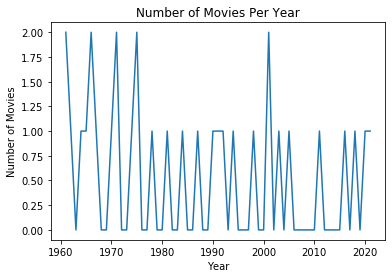

In [4]:
def analyzeActor(dbcon, actor_name):
    
    # This part of function aims to query the title of movie, year the movie premiered, the character the actor played,
    # and the age of the actor at that time from 4 tables of imdb database, and sort them from earliest premiered year to lastest premiered year.
    # After querying, the function transforms the query results to a dataframe. 
    # Finally, it prints out the results for users.
    pyquery1 = """
    SELECT t.primary_title, t.premiered, c.characters, t.premiered-p.born AS age, r.rating
    FROM titles AS t INNER JOIN crew AS c USING (title_id)
    INNER JOIN ratings AS r USING (title_id)
    INNER JOIN people AS p USING (person_id)
    WHERE p.name = :actor_in AND t.type = "movie" AND t.primary_title IS NOT NULL AND t.premiered IS NOT NULL AND c.characters IS NOT NULL AND
    t.premiered IS NOT NULL AND p.born IS NOT NULL AND r.rating IS NOT NULL
    ORDER BY t.premiered ASC
    """
    prepare_stmt1 = sa.sql.text(pyquery1)
    need_stmt1 = prepare_stmt1.bindparams(actor_in = actor_name)
    df1 = pd.read_sql_query(need_stmt1, dbcon)

    print("=====================================================")
    print("Actor: "+ actor_name)
    print("=====================================================")
    print()
    print("First appearance:")
    print("=================")
    print(str(df1.iloc[0,1]) + ': Played ' + df1.iloc[0,2][2:-2] + ' in "' + df1.iloc[0,0]+  '" (at age ' + str(df1.iloc[0,3]) +')' )
    print()
    print("Last appearance:")
    print("=================")
    print(str(df1.iloc[-1,1]) + ': Played ' + df1.iloc[-1,2][2:-2] + ' in "' + df1.iloc[-1,0]+  '" (at age ' + str(df1.iloc[-1,3]) +')' )
    print()
    
    # This part of function is same as the first part. It also does query, transform query results to a dataframe, and print out the results for users.
    # But it focus on querying the lowest and highest rated movie of any given actor/actress.
    pyquery2 = """
    SELECT t.primary_title, t.premiered, c.characters, t.premiered-p.born AS age, r.rating
    FROM titles AS t INNER JOIN crew AS c USING (title_id)
    INNER JOIN ratings AS r USING (title_id)
    INNER JOIN people AS p USING (person_id)
    WHERE p.name = :actor_in AND t.type = "movie" AND t.primary_title IS NOT NULL AND t.premiered IS NOT NULL AND c.characters IS NOT NULL AND
    t.premiered IS NOT NULL AND p.born IS NOT NULL AND r.rating IS NOT NULL
    ORDER BY r.rating ASC
    """
    prepare_stmt2 = sa.sql.text(pyquery2)
    need_stmt2 = prepare_stmt2.bindparams(actor_in = actor_name)
    df2 = pd.read_sql_query(need_stmt2, dbcon)
    
    print('Lowest rated movie: ' + str(df2.iloc[0,0]) + ' (rating = ' + str(df2.iloc[0,4]) +')')
    print('Highest rated movie: ' + str(df2.iloc[-1,0]) + ' (rating = ' + str(df2.iloc[-1,4]) + ')')
    
    # Similiar with the other 2 parts of this function, this part querys data and transforms the result to a dataframe.
    # Instead of printing out the results, it shows the number of movies per year shooted by this given actor/actress with a line graph.
    pyquery3 = """
    SELECT COUNT(DISTINCT title_id) AS num, t.premiered
    FROM titles AS t INNER JOIN crew AS c USING (title_id)
    INNER JOIN ratings AS r USING (title_id)
    INNER JOIN people AS p USING (person_id)
    WHERE p.name = :actor_in  AND t.type = "movie" AND t.primary_title IS NOT NULL AND t.premiered IS NOT NULL AND c.characters IS NOT NULL AND
    t.premiered IS NOT NULL AND p.born IS NOT NULL AND r.rating IS NOT NULL
    GROUP BY t.premiered
    """
    prepare_stmt3 = sa.sql.text(pyquery3)
    need_stmt3 = prepare_stmt3.bindparams(actor_in = actor_name)
    df3 = pd.read_sql_query(need_stmt3, dbcon)
    
    # This part is used to draw a line graph with title and labels to visualize the results.
    first = df3.premiered.min()
    last = df3.premiered.max()
    years = np.arange(first, last+1).astype(int)
    
    df3.set_index('premiered', inplace=True)
    
    df4 = df3.reindex(years, fill_value=0)
    
    plt.plot(df4)
    plt.xlabel('Year')
    plt.ylabel('Number of Movies')
    plt.title('Number of Movies Per Year')
    plt.show()

analyzeActor(connection, "Warren Beatty")


## **_Task 2 Part 1_**

**Here is my first function of Task 2. I create this function because I think someone (at least myself) is interested in the changes on the trend of rating from 2001 to 2022. To be more specific and practicable, I decide to use `type` and `region` as the parameters of this function, because we'd like to search for movies or TVs by countries and by their types. Moreover, thinking about it is also interesting and meaningful to compare the trend of ratings among diffrent types of movies, TVs, and celebrity contents in same region or the trend of ratings among same type of movies, TVs, and celebrity contents in different regions, I make this function be able to take 6 parameters composing 3 combinations of `type` and `region`.**

**I suggest that when you use this function, you'd better control one of your variables: different types in same region OR same type in different regions.**

By looking at the `titles` table of `imdb` database, I notice that there are many types of movies, TVs, and celebrity contents, and I cannot find out all of the types from sqLite, I query the list of all diffrent types in `titles` table.

In [5]:
pyquery8 = """
SELECT DISTINCT type
FROM titles
    """
prepare_stmt8 = sa.sql.text(pyquery8)
need_stmt8 = prepare_stmt8
df8 = pd.read_sql_query(need_stmt8, connection)
print(df8)

            type
0          movie
1          short
2      tvEpisode
3   tvMiniSeries
4        tvMovie
5        tvPilot
6       tvSeries
7        tvShort
8      tvSpecial
9          video
10     videoGame


**A Python function called `findSize(dbcon, m1type, m1region, m2type, m2region,m3type, m3region)` that performs SQL queries (to the database with the connection `dbcon`) to finding out 3 dataframes of average rating of given types in given regions from 2001 to 2022, and displays a multiple line graph showing 3 trends of ratings.**

In [6]:
def findSize(dbcon, m1type, m1region, m2type, m2region,m3type, m3region):
     
    # This function is made by 3 query and transformation parts and 1 graph parts. 
    # The only difference among the 3 querys is that they take differnt combinations of type and region.
    # I use INNER JOIN to get rid of all results without information I need, such as rating, premiered year, and so on.
    pyquery7 = """
    SELECT t.premiered, AVG(r.rating) AS avgRating1
    FROM ratings AS r INNER JOIN titles AS t USING (title_id)
    INNER JOIN akas AS a USING (title_id)
    WHERE a.region = :Mregion AND t.type = :Mtype AND (t.premiered > 2000) AND (r.rating IS NOT NULL) AND t.premiered IS NOT NULL
    GROUP BY t.premiered
    ORDER BY t.premiered ASC
    """
    prepare_stmt7 = sa.sql.text(pyquery7)
    need_stmt7 = prepare_stmt7.bindparams(Mtype = m1type, Mregion = m1region)
    df7 = pd.read_sql_query(need_stmt7, dbcon)


    pyquery8 = """
    SELECT t.premiered, AVG(r.rating) AS avgRating2
    FROM ratings AS r INNER JOIN titles AS t USING (title_id)
    INNER JOIN akas AS a USING (title_id)
    WHERE a.region = :Mregion AND t.type = :Mtype AND (t.premiered > 2000) AND (r.rating IS NOT NULL) AND t.premiered IS NOT NULL
    GROUP BY t.premiered
    ORDER BY t.premiered ASC
    """
    prepare_stmt8 = sa.sql.text(pyquery8)
    need_stmt8 = prepare_stmt8.bindparams(Mtype = m2type, Mregion = m2region)
    df8 = pd.read_sql_query(need_stmt8, dbcon)
  

    pyquery9 = """
    SELECT t.premiered, AVG(r.rating) AS avgRating3
    FROM ratings AS r INNER JOIN titles AS t USING (title_id)
    INNER JOIN akas AS a USING (title_id)
    WHERE a.region = :Mregion AND t.type = :Mtype AND (t.premiered > 2000) AND (r.rating IS NOT NULL) AND t.premiered IS NOT NULL
    GROUP BY t.premiered
    ORDER BY t.premiered ASC
    """
    prepare_stmt9 = sa.sql.text(pyquery9)
    need_stmt9 = prepare_stmt9.bindparams(Mtype = m3type, Mregion = m3region)
    df9 = pd.read_sql_query(need_stmt9, dbcon)
    
    # For this part, I extract the variables I need from 3 dataframes to lists.
    # This step is the preparetion for the multiple line graph.
    year = list(df7.premiered)
    list1 = list(df7.avgRating1)
    list2 = list(df8.avgRating2)
    list3 = list(df9.avgRating3)
    
    # At the end of this function, it draws a multiple line graph with title, labels, and legend of 3 trendings of average rating
    # of given types in given regions from 2001 to 2022.
    print('Here is the line graph which shows the trends of rating from 2001 to 2022 of the 3 objections you chose:')
    
    plt.plot(year,list1, color = 'blue', label = '1')
    plt.plot(year,list2, color = 'orange', label =  '2')
    plt.plot(year,list3, color = 'yellow', label="3")
    plt.xlabel('Year')
    plt.ylabel('Rating')
    plt.title('Trends of Rating from 2001 to 2022')
    plt.legend(loc = 'lower left')
    plt.show()


**Here is an example of using this fuction to find something interesting me.
I wonder how Japanese short films, movies, and tvMovies behaved from 2001 to 2022.**

Here is the line graph which shows the trends of rating from 2001 to 2022 of the 3 objections you chose:


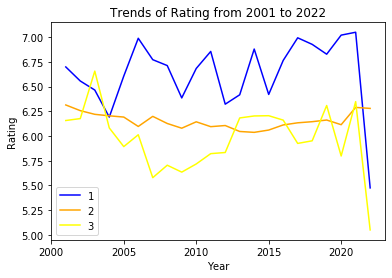

In [7]:
findSize(connection, 'short', 'JP', 'movie', 'JP', 'tvMovie', 'JP')

Notice the blue line represents the rating of Japanese short films, the orange line represents the rating of Japanese movies, and the yellow one represents that of Japanese tvMovies, according to the legend at the lower left corner. From the graph, we see that the behavior of Japanese movies is relatively steady and ratings of both Japanese short films and tvMovies have been changed a lot from 2001 to 2022. This graph makes me curious about what happens in the Japanese film industry in 2006 and this year, since the average ratings of both short films and tvMovies reached a relatively max value in 2006 and rapidly decrease in 2022. 

**Since we have already tried the function with different types in a same region, this example is about a same type in different regions. Here is an example showing how Japanese movies, American movies, and Franch movies behaved from 2001 to 2022.**

Here is the line graph which shows the trends of rating from 2001 to 2022 of the 3 objections you chose:


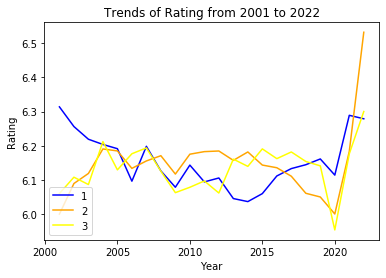

In [8]:
findSize(connection, 'movie', 'JP', 'movie', 'US', 'movie', 'FR')

Notice the blue line represents the rating of Japanese movies, the orange line represents the rating of American movies, and the yellow one represents that of Franch movies, according to the legend at the lower left corner. You may wonder tht why the trend of rating of Japanese movies looks somehow steady, but not in this graph. Please be careful that this graph has a different scale from the last example. Since the scale of this graph is roughly from 6 to 6.5, compare with to the last example, we know that actually the movies in all of these 3 regions behaved steady from 2001 to 2022. Moreover, the increasing trend from 2020 to 2022 also make me curious about it. Combinding with the result we got from last example, I really want to know if the increasing on the average rating of movies and the decreasing on the average rating of short films and tvMovies around 2022 also happened in other regions.

## **_Task 2 Part 2_**

**Here is my second function of Task 2. It is a Python function called `findCountry(dbcon, region, low, high)` that performs SQL queries (to the database with the connection dbcon) to determine some interesting facts about the provided rating range and region. Specifically, the function should only examine movies and display the following information:**

1. The region having the highest average movie rating in the given range of rating.
2. The information of the top 5 movies with highest rating in the given range in the region in part 1 (if the rating is same, then the order is depending on the number of votes).
3. A bar graph showing the top 10 regions having the highest average movie rating in the given range of rating and their average rating score.

**A Python function called `analyzeRating(dbcon, low, high)` that performs 2 SQL queries (to the database with the connection dbcon), transforms the results to dataframes, and draws a horizontal bar graph according to the result.**

**Notice that there are 2 fuctions in my codes, but one is called in the other one.**

In [9]:
def findCountry(dbcon, region, low, high):
    
    # As I just mentioned, this is the function which will be called in the next function which is also the main one.
    # I use Region gotten from last step as a new parameter of this function.
    # For this query, it querys the movies with highest rating among the given range in the region which has the highest average 
    # rating in the given rating range of movies.
    # It also transforms the result to a dataframe.
    # It prints out the top 5 movies using the information in dataframe.
    pyquery6 = """
    SELECT DISTINCT t.primary_title, r.rating, t.premiered, r.votes, t.is_adult
    FROM titles AS t INNER JOIN crew AS c USING (title_id)
    INNER JOIN ratings AS r USING (title_id)
    INNER JOIN akas AS a USING (title_id)
    WHERE a.region = :Region AND (r.rating BETWEEN :Low AND :High) AND t.type = "movie" AND t.primary_title IS NOT NULL AND
    r.rating IS NOT NULL AND t.premiered IS NOT NULL AND r.votes IS NOT NULL AND t.is_adult IS NOT NULL
    ORDER BY r.rating DESC, r.votes DESC
    """
    prepare_stmt6 = sa.sql.text(pyquery6)
    need_stmt6 = prepare_stmt6.bindparams(Region = region, Low = low, High = high)
    df6 = pd.read_sql_query(need_stmt6, dbcon)
    df6['children'] = np.where(df6['is_adult'] == 0, 'can', 'cannot')
    print('The top 5 movies with rating in the given range in ' + region + ' are:')
    print('1. "' + str(df6.iloc[0,0]) + '" [Rating ' + str(df6.iloc[0,1]) + '] premiered in ' + str(df6.iloc[0,2]) + ' with ' + str(df6.iloc[0,3]) + ' votes (' + df6.iloc[0,-1] + ' be watched by childrens)')
    print('2. "' + str(df6.iloc[1,0]) + '" [Rating ' + str(df6.iloc[1,1]) + '] premiered in ' + str(df6.iloc[1,2]) + ' with ' + str(df6.iloc[1,3]) + ' votes (' + df6.iloc[1,-1] + ' be watched by childrens)')
    print('3. "' + str(df6.iloc[2,0]) + '" [Rating ' + str(df6.iloc[2,1]) + '] premiered in ' + str(df6.iloc[2,2]) + ' with ' + str(df6.iloc[2,3]) + ' votes (' + df6.iloc[2,-1] + ' be watched by childrens)')
    print('4. "' + str(df6.iloc[3,0]) + '" [Rating ' + str(df6.iloc[3,1]) + '] premiered in ' + str(df6.iloc[3,2]) + ' with ' + str(df6.iloc[3,3]) + ' votes (' + df6.iloc[3,-1] + ' be watched by childrens)')
    print('5. "' + str(df6.iloc[4,0]) + '" [Rating ' + str(df6.iloc[4,1]) + '] premiered in ' + str(df6.iloc[4,2]) + ' with ' + str(df6.iloc[4,3]) + ' votes (' + df6.iloc[4,-1] + ' be watched by childrens)')
    print()

def analyzeRating(dbcon, low, high):
    
    # This query is actually the first part of this function.
    # This part can help us to query the averge rating in the given range of movies in each region and sort them with descending order.
    # Notice that since I am going to print out the top 5 movies in a same region, I filter all regions with less than 5 movies in the given range.
    # It is also because I think that if the number of movies is less than 5, then it may not be representative enough.
    # Same as the other functions, I transform them to dataframe aftering getting the query results, and print out the result to users using some certain value in the dataframe.
    pyquery5 = """
    SELECT a.region, AVG(r.rating) AS avgRating, COUNT(DISTINCT title_id) AS Mnum
    FROM titles AS t INNER JOIN crew AS c USING (title_id)
    INNER JOIN ratings AS r USING (title_id)
    INNER JOIN people AS p USING (person_id)
    INNER JOIN akas AS a USING (title_id)
    WHERE (r.rating BETWEEN :Low AND :High) AND t.type = "movie" AND a.region IS NOT NULL AND t.primary_title IS NOT NULL AND
    r.rating IS NOT NULL AND t.premiered IS NOT NULL AND r.votes IS NOT NULL AND t.is_adult IS NOT NULL
    GROUP BY a.region
    HAVING Mnum > 4
    ORDER BY avgRating DESC
    """
    prepare_stmt5 = sa.sql.text(pyquery5)
    need_stmt5 = prepare_stmt5.bindparams(Low = low, High = high)
    df5 = pd.read_sql_query(need_stmt5, dbcon)
    Region = str(df5.iloc[0,0])                                                                                                  
    print('Region ' + Region + ' has the highest average movie rating in the range from ' + str(low) + ' to ' + str(high) + '.')
    print()
    
    # Here, I call the other function
    findCountry(dbcon, Region, low, high)
    
    # This part is to draw a horizontal bar graph with title and labels to show the top 10 regions 
    # having the highest average movie rating in the given range of rating and their average rating score.
    df5short = df5.iloc[:,:2].head(10)
    
    Re = list(df5short.region)
    Ar = list(df5short.avgRating)
    plt.barh(Re,Ar, facecolor = 'maroon', edgecolor = 'peru', alpha = 0.7)
    plt.xlim(low,high)
    ax = plt.gca()
    ax.invert_yaxis()
    plt.title('Top 10 Regions with Highest Average Movie Rating')
    plt.ylabel('Region')
    plt.xlabel('Rating')
    plt.show()


**Let's try to find out what we can get in the range of rating is from 7 to 8.**

Region BUMM has the highest average movie rating in the range from 7 to 8.

The top 5 movies with rating in the given range in BUMM are:
1. "Padauk Musical" [Rating 7.9] premiered in 2020 with 61 votes (can be watched by childrens)
2. "Mya ga naing" [Rating 7.9] premiered in 1996 with 22 votes (can be watched by childrens)
3. "Hlyo-hwat-thaw-hnin" [Rating 7.8] premiered in 2005 with 23 votes (can be watched by childrens)
4. "Journey to the Death" [Rating 7.8] premiered in 2019 with 6 votes (can be watched by childrens)
5. "Testing Movie1" [Rating 7.2] premiered in 2015 with 95 votes (can be watched by childrens)



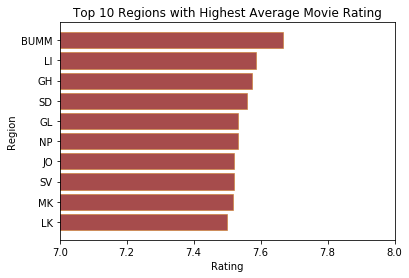

In [10]:
analyzeRating(connection, 7, 8)

From the result shown, we can learn that Region BUMM has the highest average movie rating in the given range. The gap between average ratings of BUMM and LI is relatively large, so we can tell the movies in BUMM does behave the best in the rating range of 7 and 8.

**What is the case when the range of ratings is from 7 to 9.**

Region SL has the highest average movie rating in the range from 7 to 9.

The top 5 movies with rating in the given range in SL are:
1. "An Education: The Story of a Witness" [Rating 8.9] premiered in 2018 with 11 votes (can be watched by childrens)
2. "They Are We" [Rating 8.6] premiered in 2014 with 20 votes (can be watched by childrens)
3. "The Language You Cry In" [Rating 8.0] premiered in 1998 with 26 votes (can be watched by childrens)
4. "Survivors" [Rating 7.9] premiered in 2018 with 27 votes (can be watched by childrens)
5. "Shado'man" [Rating 7.7] premiered in 2013 with 10 votes (can be watched by childrens)



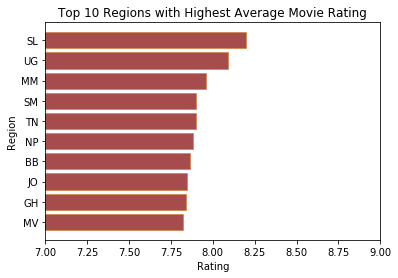

In [11]:
analyzeRating(connection, 7, 9)

From the result shown, we can learn that Region SL has the highest average movie rating in the given range. The gap among average ratings of SL, UG, and MM is relatively large, so we can tell the movies in SL and UG do behave the best in the rating range of 7 and 9. 
I didn't change the low boundary of the range rating, and I make the upper boundary larger. Since I want to see which region in the last example may show up again in this example. For the regions which also is top 10 region with highest average rating in the range, we can tell that they not only behave well in the 7-8 zone, they actually even behave better, becasue they also have many movies with rating in the range of 8-9. Notice that GH, NP, and JO show up in this graph as well. These 3 regions are very potential.

**It is the Python code to close the database connection and delete the engine In the code cell below.**

In [12]:
try:
    connection.close()
except:
    pass
del engine